In [17]:
import pandas as pd

In [18]:
df = pd.read_parquet("datasets/new_summit_gpu_clean.parquet")
print(df.shape)
print(df["is_failure"].value_counts())

(50259, 119)
is_failure
0    49964
1      295
Name: count, dtype: int64


In [19]:
#building anomaly dataset (using NORMAL samples only)
normal_df = df[df["is_failure"] == 0].copy()
X_anom = normal_df.drop(columns=["is_failure"])

print(X_anom.shape)

(49964, 118)


In [20]:
#Scaling features (important for anomaly scoring)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_anom)


#Saving the scaler
import joblib
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [21]:
#raining anomaly detector (Isolation Forest)
from sklearn.ensemble import IsolationForest

anom_model = IsolationForest(
    n_estimators=300,
    contamination=0.05,#doesnt affect becz we r using manually percentile
    random_state=42
)

anom_model.fit(X_scaled)

import joblib
joblib.dump(anom_model, "anomaly_model.pkl")

['anomaly_model.pkl']

In [22]:
#Score ALL samples (normal + failure)

#Preparing full matrix
X_full = df.drop(columns=["is_failure"])
X_full_scaled = scaler.transform(X_full)


#Compute anomaly scores
df["anomaly_score"] = -anom_model.decision_function(X_full_scaled)

#Higher score means more abnormal.

In [23]:
#here we are converting anomaly scores into risk classes
#we r computing thresholds from normal samples ony=ly.
low_thr, med_thr = df[df["is_failure"] == 0]["anomaly_score"].quantile([0.80, 0.95])

#assigning risk levels
def assign_risk(score):
    if score <= low_thr:
        return "low"
    elif score <= med_thr:
        return "medium"
    else:
        return "high"

df["risk_level"] = df["anomaly_score"].apply(assign_risk)


#checking distribution

print(df["risk_level"].value_counts())
print(df.groupby("risk_level")["is_failure"].mean())

#note: High risk bucket should contain a much higher failure rate than low.

risk_level
low       40148
medium     7573
high       2538
Name: count, dtype: int64
risk_level
high      0.015366
low       0.004409
medium    0.010432
Name: is_failure, dtype: float64


In [24]:
pd.crosstab(df["risk_level"], df["is_failure"], normalize="index")

is_failure,0,1
risk_level,,
high,0.984634,0.015366
low,0.995591,0.004409
medium,0.989568,0.010432


<h1>STAGE 2: FAILURE CLASSIFIER (high-risk normals vs DBE failures)</h2>

In [34]:
# keep only:
# - real failures
# - high-risk normals

stage2_df = df[
    (df["is_failure"] == 1) |
    ((df["risk_level"] == "high") & (df["is_failure"] == 0))
].copy()

print(stage2_df["is_failure"].value_counts())

is_failure
0    2499
1     295
Name: count, dtype: int64


In [35]:
#Include anomaly_score as an extra feature.

X = stage2_df.drop(columns=["is_failure", "risk_level"])
y = stage2_df["is_failure"]


In [36]:
import joblib

scaler = joblib.load("scaler.pkl")

# Scale only the original telemetry features (exclude anomaly_score)
X_no_score = X.drop(columns=["anomaly_score"])
X_scaled = scaler.transform(X_no_score)

# Add anomaly_score back AFTER scaling
import numpy as np
X_final = np.column_stack([X_scaled, X["anomaly_score"].values])

In [41]:
#Compute class weight
neg = (y == 0).sum()
pos = (y == 1).sum()
scale_pos_weight = neg / pos

print("scale_pos_weight =", scale_pos_weight)

scale_pos_weight = 8.471186440677966


In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_final,
    y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

In [43]:
#Train XGBoost classifier

from xgboost import XGBClassifier

clf = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=42
)

clf.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [44]:
#Evaluate model

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

y_prob = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("PR-AUC:", average_precision_score(y_test, y_prob))

[[747   3]
 [  7  82]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       750
           1       0.96      0.92      0.94        89

    accuracy                           0.99       839
   macro avg       0.98      0.96      0.97       839
weighted avg       0.99      0.99      0.99       839

ROC-AUC: 0.9789812734082396
PR-AUC: 0.9667449724958814


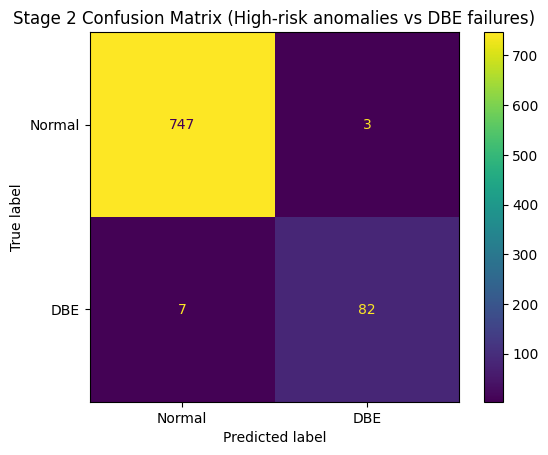

In [46]:
#CONFUSION MATRIX

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "DBE"])
disp.plot()

plt.title("Stage 2 Confusion Matrix (High-risk anomalies vs DBE failures)")
plt.show()

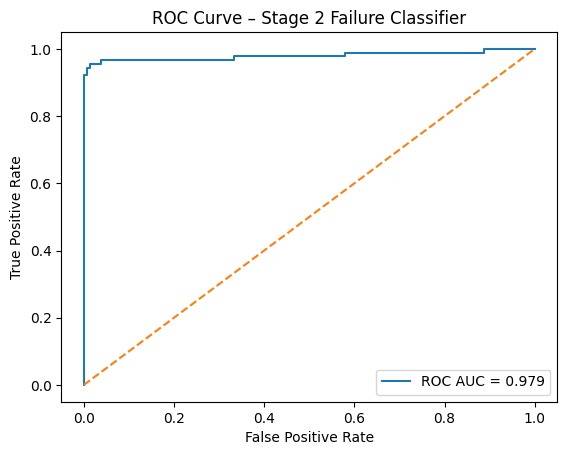

In [47]:
#ROC CURVE

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Stage 2 Failure Classifier")
plt.legend()
plt.show()

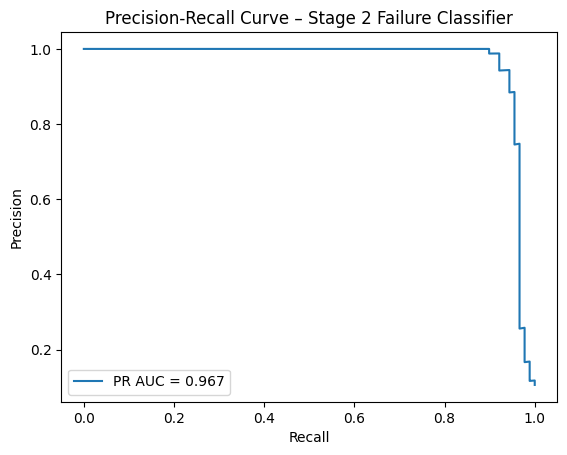

In [48]:
#PRECISION-RECALL CURVE (this is the most important)

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)

plt.figure()
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve – Stage 2 Failure Classifier")
plt.legend()
plt.show()

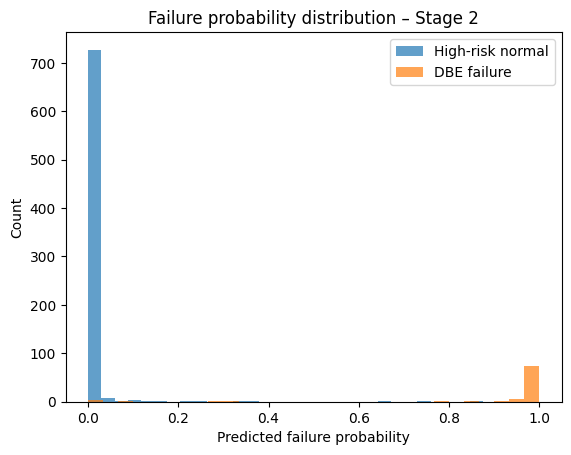

In [51]:
#FAILURE PROBABILITY DISTRIBUTION
#demonstrating separation between classes.

import matplotlib.pyplot as plt

plt.figure()
plt.hist(y_prob[y_test == 0], bins=30, alpha=0.7, label="High-risk normal")
plt.hist(y_prob[y_test == 1], bins=30, alpha=0.7, label="DBE failure")
plt.xlabel("Predicted failure probability")
plt.ylabel("Count")
plt.title("Failure probability distribution – Stage 2")
plt.legend()
plt.show()

In [45]:
#Save model
joblib.dump(clf, "failure_model.pkl")

['failure_model.pkl']